# Bayesian Regression

(Example from https://pyro.ai/examples/bayesian_regression.html the dataset is not working! So use https://www.kaggle.com/datasets/budincsevity/szeged-weather/data)

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def optimize(params_dict, loss_function, y, cfg, steps=500):
    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=1)

    total_start = time()

    for i in range(steps):

        optimizer.zero_grad()  # Reset gradients
        
        # loss
        current_dist = start_SOGA(cfg, params_dict)

        loss = loss_function(y, current_dist)

        # Backpropagate
        loss.backward(retain_graph=True)
        
        optimizer.step()

        # Print progress
        if i % 10 == 0:
            out = ''
            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
            out = out + f" loss: {loss.item()}"
            print(out)

    total_end = time()

    print('Optimization performed in ', round(total_end-total_start, 3))

### Linear regression (not Bayesian)

We are given a dataset $D = {(X_i, y_i)}$.

The goal of linear regression is to fit a function of the form: $$y = wX+b+\epsilon$$

where $w$ and $b$ are learnable parameters and $\epsilon$ observation noise.

tensor([0.3100, 0.3400, 0.3500, 0.3700, 0.3900, 0.3900, 0.4000, 0.4000, 0.4100,
        0.4300, 0.4600, 0.4700, 0.5100, 0.5500, 0.5700, 0.5900, 0.6000, 0.6100,
        0.6700, 0.6800, 0.7000, 0.7100, 0.7200, 0.7300, 0.7400, 0.7500, 0.7600,
        0.7700, 0.7800, 0.9200])


Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

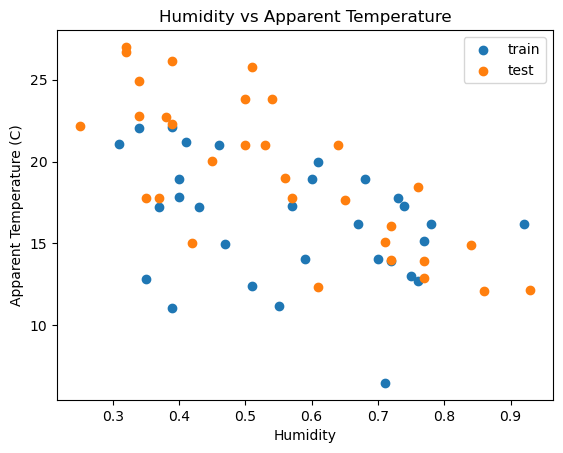

In [4]:
'''
Import the dataset
'''

weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
#Let's reduce the size of the dataset by considering one row for each day (corresponding to 16:00), only in 2015
#Training: April, Test: May
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)
X = torch.tensor(data["Humidity"].to_numpy())
y = torch.tensor(data["Apparent Temperature (C)"].to_numpy())

sort_idx = np.argsort(X)

X = X[sort_idx]
y = y[sort_idx]

print(X)

plt.scatter(X, y, label = "train")
plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"],label = "test")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

In [5]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/linear_regression.soga')
cfg = produce_cfg(compiledFile)

pars = {'w':-5., 'b':10.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

In [6]:
def mean_squared_error(y_true, dist):
    return torch.mean((y_true - dist.gm.mean()) ** 2)

def mean_squared_error_bayes(y_true, dist):
    #This works for the means but of course not for the variances
    return torch.mean((y_true - dist.gm.mean()[:-2]) ** 2)

def neg_log_likelihood(y_true, dist):
    #Calculate the log-likelihood of the data given the distribution
    neg_log_likelihood = 0
    for i in range(len(dist.gm.mean())-2):
        neg_log_likelihood -= torch.log(dist.gm.marg_pdf(y_true[i].unsqueeze(0), i))
    return neg_log_likelihood

In [7]:
optimize(params_dict, mean_squared_error, y, cfg)
y_pred_ML = params_dict['w'].detach().numpy()*X.detach().numpy()+params_dict['b'].detach().numpy()

w: -4.000000000974376 b: 10.999999999453816  loss: 95.59987242798353
w: 2.680778261553717 b: 18.013720392093624  loss: 23.254617816423508
w: -0.32484667710684334 b: 16.004087311427135  loss: 13.305686189044517
w: -1.3774024210820013 b: 16.079028344941143  loss: 14.334811983088905
w: -1.0450004937940203 b: 17.60359819806139  loss: 13.436251546325302
w: -2.6135574792392573 b: 17.27286655730318  loss: 12.584456893079308
w: -3.0037940071336995 b: 18.084543094487312  loss: 12.233726928935873
w: -3.8389723031055314 b: 18.39572699796174  loss: 12.045087391030115
w: -4.499507146076721 b: 18.793621904490948  loss: 11.903465819158434
w: -5.078222596763667 b: 19.17016507542894  loss: 11.794703375599287
w: -5.634278143352659 b: 19.458496464578474  loss: 11.715160475322646
w: -6.077958901227512 b: 19.745712075746088  loss: 11.65937531577552
w: -6.4795296506526965 b: 19.965566658398075  loss: 11.62157742081221
w: -6.801471856974659 b: 20.162174256150177  loss: 11.596771417845302
w: -7.07116551694561

Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

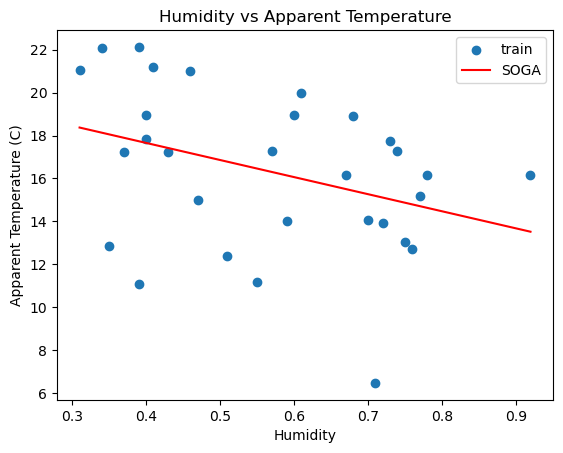

In [8]:
plt.scatter(X, y, label = "train")
plt.plot(X, y_pred_ML, color='red', label = "SOGA")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

### Bayesian Regression

In [9]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bayesian_linear_regression.soga')
cfg = produce_cfg(compiledFile)

pars = {'muw':-10., 'mub':10., 'sigmaw':1., 'sigmab':1., 'sigmay':1.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

optimize(params_dict, neg_log_likelihood, y, cfg, steps=1000)

#predictive mean
y_pred = params_dict['muw'].detach().numpy()*X.detach().numpy()+params_dict['mub'].detach().numpy()

#predictive variance
sigma_y_pred = np.sqrt(params_dict['sigmay'].detach().numpy()**2 + (X.detach().numpy()*params_dict['sigmaw'].detach().numpy())**2 + params_dict['sigmab'].detach().numpy()**2)



muw: -9.000000000116106 mub: 10.999999999934957 sigmaw: 1.9999999999638827 sigmab: 1.9999999999881313 sigmay: 1.9999999999881313  loss: 1036.3428829658117
muw: -4.1799027195986405 mub: 15.832612390196475 sigmaw: 5.779491206630712 sigmab: 5.794765266067352 sigmay: 5.794765266067352  loss: 96.7920808047189
muw: -2.4279782741233373 mub: 17.605298063593356 sigmaw: 6.868917389326895 sigmab: 6.895617357693813 sigmay: 6.895617357693813  loss: 99.71767798419812
muw: -1.757956618876398 mub: 18.30037883355569 sigmaw: 7.216648260960447 sigmab: 7.250607581722195 sigmay: 7.250607581722195  loss: 101.34342782823028
muw: -1.5701765295677133 mub: 18.516924901736342 sigmaw: 7.275905671202243 sigmab: 7.3147779657469245 sigmay: 7.3147779657469245  loss: 101.74793611434049
muw: -1.601948040498246 mub: 18.517543882047544 sigmaw: 7.213880958936854 sigmab: 7.256606995185614 sigmay: 7.256606995185614  loss: 101.5651010609588
muw: -1.7295735460462003 mub: 18.42592956769003 sigmaw: 7.095861779821859 sigmab: 7.1

Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

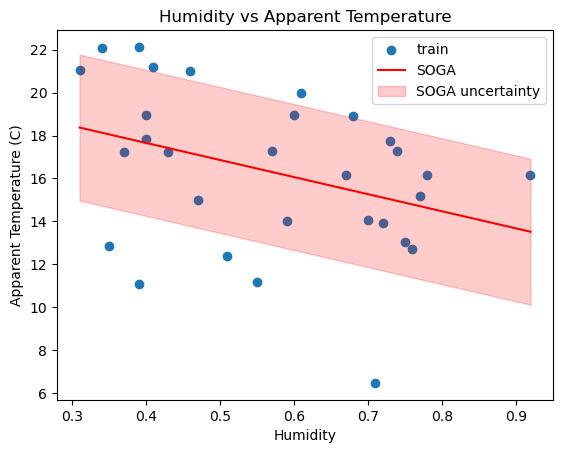

In [10]:

plt.scatter(X, y, label = "train")
plt.plot(X, y_pred, color='red', label = "SOGA")
plt.fill_between(X, y_pred - sigma_y_pred, 
                 y_pred + sigma_y_pred, 
                 color='red', alpha=0.2, label = "SOGA uncertainty")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

Let's try to fix the means and perform inference on the variances

sigmaw: 1.9999999993326898 sigmab: 1.9999999998100813 sigmay: 1.9999999998100813  loss: 115.49065912218856
sigmaw: 4.553628602275754 sigmab: 4.800174490039298 sigmay: 4.800174490039298  loss: 90.22944346039085
sigmaw: 3.7823461970369054 sigmab: 4.314500381109742 sigmay: 4.314500381109742  loss: 88.45287920409693
sigmaw: 1.9140393696781528 sigmab: 2.6720035384978957 sigmay: 2.6720035384978957  loss: 80.62282275050768
sigmaw: 0.7450200483215371 sigmab: 2.181335360317669 sigmay: 2.1813353603176675  loss: 79.97808599460721
sigmaw: 0.4937346155779916 sigmab: 2.7270999126214313 sigmay: 2.727099912621429  loss: 79.81781737082717
sigmaw: 0.14184428425480483 sigmab: 2.23597400687417 sigmay: 2.2359740068741685  loss: 79.41876199609305
sigmaw: -0.006404601603560742 sigmab: 2.5062572761071022 sigmay: 2.506257276107101  loss: 79.31782385577094
sigmaw: -0.05624894168392469 sigmab: 2.355499144053424 sigmay: 2.3554991440534225  loss: 79.28562521954053
sigmaw: -0.06097520971895063 sigmab: 2.43259836786

Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

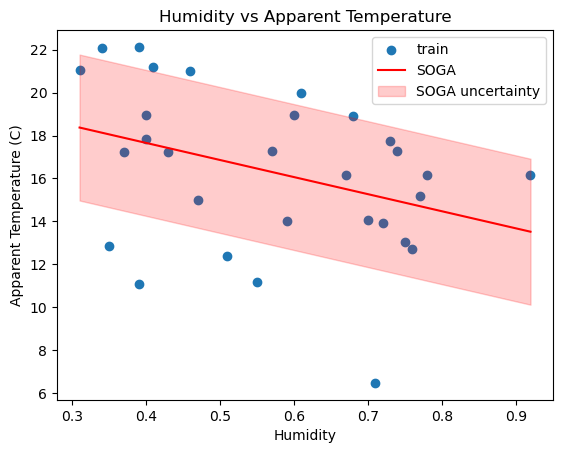

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/bayesian_linear_regression2.soga')
cfg = produce_cfg(compiledFile)

pars = {'sigmaw':1., 'sigmab':1., 'sigmay':1.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

optimize(params_dict, neg_log_likelihood, y, cfg, steps=1000)


#predictive variance
sigma_y_pred = np.sqrt(params_dict['sigmay'].detach().numpy()**2 + (X.detach().numpy()*params_dict['sigmaw'].detach().numpy())**2 + params_dict['sigmab'].detach().numpy()**2)

plt.scatter(X, y, label = "train")
plt.plot(X, y_pred_ML, color='red', label = "SOGA")
plt.fill_between(X, y_pred - sigma_y_pred, 
                 y_pred + sigma_y_pred, 
                 color='red', alpha=0.2, label = "SOGA uncertainty")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

### WITH PYRO

In [12]:
import pyro
from torch import nn
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.nn import PyroSample

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

# Regression model
linear_reg_model = PyroModule[nn.Linear](1, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=1)
num_iterations = 1500

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(X.unsqueeze(1))
    # calculate the mse loss
    loss = loss_fn(y_pred.squeeze(1), y)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())


[iteration 0050] loss: 513.7189
[iteration 0100] loss: 419.6590
[iteration 0150] loss: 370.4817
[iteration 0200] loss: 352.6952
[iteration 0250] loss: 347.9068
[iteration 0300] loss: 346.9234
[iteration 0350] loss: 346.7678
[iteration 0400] loss: 346.7489
[iteration 0450] loss: 346.7471
[iteration 0500] loss: 346.7470
[iteration 0550] loss: 346.7470
[iteration 0600] loss: 346.7470
[iteration 0650] loss: 346.7470
[iteration 0700] loss: 346.7470
[iteration 0750] loss: 346.7470
[iteration 0800] loss: 346.7470
[iteration 0850] loss: 346.7470
[iteration 0900] loss: 346.7470
[iteration 0950] loss: 346.7470
[iteration 1000] loss: 346.7470
[iteration 1050] loss: 346.7470
[iteration 1100] loss: 346.7470
[iteration 1150] loss: 346.7470
[iteration 1200] loss: 346.7470
[iteration 1250] loss: 346.7470
[iteration 1300] loss: 346.7470
[iteration 1350] loss: 346.7470
[iteration 1400] loss: 346.7470
[iteration 1450] loss: 346.7470
[iteration 1500] loss: 346.7470
Learned parameters:
weight [[-7.95600669

### Bayesian Regression

In [53]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-10., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(10., 1.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Normal(0., 1.))
        mean = self.linear(x.unsqueeze(1)).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
    
num_iterations = 8000
model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X, y)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 1432.3815
[iteration 0101] loss: 7.3850
[iteration 0201] loss: 5.5829
[iteration 0301] loss: 4.8750
[iteration 0401] loss: 4.6672
[iteration 0501] loss: 4.5894
[iteration 0601] loss: 4.6411
[iteration 0701] loss: 4.6060
[iteration 0801] loss: 4.5746
[iteration 0901] loss: 4.4877
[iteration 1001] loss: 4.5117
[iteration 1101] loss: 4.4822
[iteration 1201] loss: 4.5142
[iteration 1301] loss: 4.5167
[iteration 1401] loss: 4.5030
[iteration 1501] loss: 4.4737
[iteration 1601] loss: 4.4619
[iteration 1701] loss: 4.3991
[iteration 1801] loss: 4.4692
[iteration 1901] loss: 4.4128
[iteration 2001] loss: 4.4184
[iteration 2101] loss: 4.4071
[iteration 2201] loss: 4.3547
[iteration 2301] loss: 4.3898
[iteration 2401] loss: 4.4001
[iteration 2501] loss: 4.3396
[iteration 2601] loss: 4.3972
[iteration 2701] loss: 4.3749
[iteration 2801] loss: 4.3346
[iteration 2901] loss: 4.3191
[iteration 3001] loss: 4.3301
[iteration 3101] loss: 4.3278
[iteration 3201] loss: 4.3253
[iterat

In [54]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 4.0418, -6.1125, 16.5829])
AutoDiagonalNormal.scale tensor([0.3743, 0.5078, 0.4663])


In [62]:
sigmay = pyro.param("AutoDiagonalNormal.scale")[0].detach().numpy()
sigmaw = pyro.param("AutoDiagonalNormal.scale")[1].detach().numpy()
sigmab = pyro.param("AutoDiagonalNormal.scale")[2].detach().numpy()

muy = pyro.param("AutoDiagonalNormal.loc")[0].detach().numpy()
muw = pyro.param("AutoDiagonalNormal.loc")[1].detach().numpy()
mub = pyro.param("AutoDiagonalNormal.loc")[2].detach().numpy()



Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

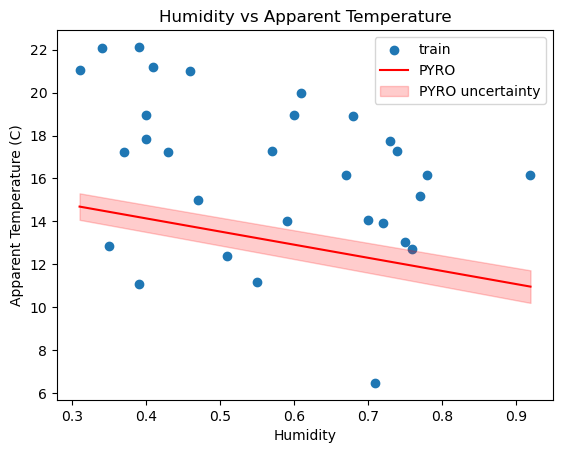

In [63]:
y_pred = muw*X.detach().numpy()+mub
sigma_y_pred = np.sqrt(sigmay**2 + (X.detach().numpy()*sigmaw)**2 + sigmab**2)

plt.scatter(X, y, label = "train")
plt.plot(X, y_pred, color='red', label = "PYRO")
plt.fill_between(X, y_pred - sigma_y_pred, 
                 y_pred + sigma_y_pred, 
                 color='red', alpha=0.2, label = "PYRO uncertainty")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

In [37]:
sigma_y_pred 

array([1.21304263, 1.21414157, 1.21453019, 1.21534082, 1.2161959 ,
       1.2161959 , 1.21664008, 1.21664008, 1.21709533, 1.21803903,
       1.21953732, 1.22005876, 1.22225424, 1.22462451, 1.22587487,
       1.22716855, 1.22783159, 1.22850541, 1.2327736 , 1.23352234,
       1.23505169, 1.23583226, 1.2366234 , 1.23742508, 1.23823729,
       1.23906001, 1.23989322, 1.24073689, 1.241591  , 1.2546328 ])